In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import random

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [11]:
class MyModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(196, 512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.Mish(),
            nn.Linear(512, 1),
        )
        
    def forward(self, x):
        return self.mlp(x)

In [12]:
batch_size = 256

model = MyModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

losses = []

In [13]:

for i in tqdm(range(1000)):

    obs = torch.normal(0, 1, size=(batch_size, 4))

    param_w1 = torch.normal(0, 3, size=(batch_size, 4, 32)) * np.sqrt(1/32)
    param_b1 = torch.normal(0, 0.001, size=(batch_size, 1, 32)) * np.sqrt(16)
    param_w2 = torch.normal(0, 3, size=(batch_size, 32, 1)) * np.sqrt(1/16)


    # Target:
    x = torch.unsqueeze(obs, -2) # [batch, (pairs), 1, features_in]
    x = torch.matmul(x.cpu(), param_w1) # [batch, (pairs), 1, features_out]
    x = x + param_b1
    x = torch.tanh(x)
    r = torch.matmul(x, param_w2) # [batch, (pairs), 1, 1]
    r = r.squeeze(-1).squeeze(-1) # [batch, (pairs)]
    r = torch.clip(r, -1, 1)
    target = r
    
    x = torch.concat((
            obs, 
            param_w1.reshape(batch_size, -1), 
            param_b1.reshape(batch_size, -1), 
            param_w2.reshape(batch_size, -1)
        ), 
        dim=-1
    )
    
    y = model(x).squeeze(-1)
    
    
    loss = criterion(y, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    break
    if i % 20 == 0:
        clear_output(True)
        plt.plot(losses)
        # plt.ylim([0, 0.5])
        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]


(array([ 1.,  5., 15., 38., 64., 66., 42., 16.,  7.,  2.]),
 array([-0.05238729, -0.04369769, -0.0350081 , -0.02631851, -0.01762892,
        -0.00893933, -0.00024973,  0.00843986,  0.01712945,  0.02581904,
         0.03450863]),
 <BarContainer object of 10 artists>)

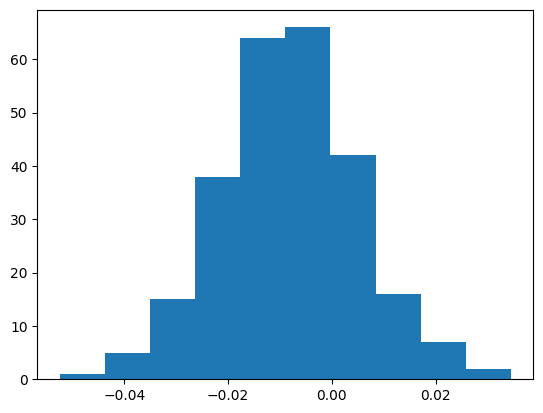

In [14]:
plt.hist(y.detach())

---

In [479]:
z_dim = 16

In [541]:
class RewardModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(z_dim + 2, 512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.Mish(),
            nn.Linear(512, 1),
            # nn.Tanh()
        )
        
    def forward(self, x):
        return self.mlp(x)
    

In [542]:
def cross_correlation_matrix(X):
    X = X - X.mean(dim=1, keepdim=True)
    X = X / (X.std(dim=1, keepdim=True) + 1e-8)  # Avoid division by zero

    # Compute cross-correlation matrix
    return torch.matmul(X, X.T) / X.shape[1]

In [543]:
s1, s2 = torch.linspace(-1, 1, 20), torch.linspace(-1, 1, 20)
# s1, s2 = torch.rand((50,)) * 2 - 1, torch.rand((50,)) * 2 - 1
grid_s1, grid_s2 = torch.meshgrid(s1, s2, indexing='ij')
s = torch.stack([grid_s1.flatten(), grid_s2.flatten()], dim=-1)

In [544]:
model = RewardModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

In [545]:
for i in tqdm(range(10000)):
    z = torch.normal(0, 1, size=(32, z_dim,))

    x = torch.concat(
        (
            s.unsqueeze(0).repeat(32, 1, 1),
            z.unsqueeze(1).repeat(1, s.shape[0], 1)
        ),
        dim=-1
    )

    x = x.to(device)
    r = model(x).squeeze(-1)

    # Cross correlation:
    r = r - r.mean(dim=1, keepdim=True)
    r = r / (r.std(dim=1, keepdim=True) + 1e-8)
    corr = torch.matmul(r, r.T) / r.shape[1]

    # # Euclidian distance:
    # z_norm = (z**2).sum(dim=1, keepdim=True)
    # D_squared = z_norm + z_norm.T - 2 * (z @ z.T)
    # weight = torch.clamp(D_squared, min=0.0)
    
    # Cosine similarity:
    z_norm = z / (z.norm(dim=1, keepdim=True) + 1e-8)  # Normalize rows
    cosine_similarity = z_norm @ z_norm.T  # Compute cosine similarity
    weight = 1 - cosine_similarity

    corr = torch.clip(corr, 0.1, 1)
    
    weighted_corr = weight.to(device) * corr
    # weighted_corr = corr
    
    
    mask = torch.triu(torch.ones_like(corr, dtype=torch.bool), diagonal=1)


    loss = weighted_corr[mask].mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    if i % 20 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        clear_output(True)
        axs[0].plot(losses)
        axs[1].imshow(corr.detach().cpu())
        # plt.ylim([0, 0.5])
        plt.show()

 18%|█▊        | 1780/10000 [00:36<02:49, 48.54it/s]


KeyboardInterrupt: 

In [546]:
s1, s2 = torch.linspace(-1, 1, 100), torch.linspace(-1, 1, 100)
# s1, s2 = torch.rand((50,)) * 2 - 1, torch.rand((50,)) * 2 - 1
grid_s1, grid_s2 = torch.meshgrid(s1, s2, indexing='ij')
eval_s = torch.stack([grid_s1.flatten(), grid_s2.flatten()], dim=-1)

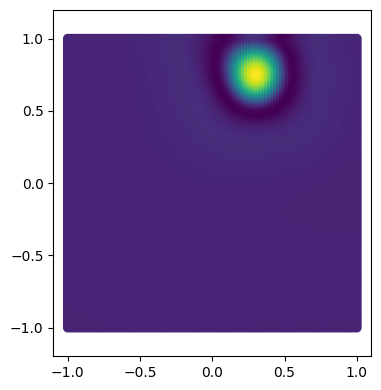

In [549]:
z1 = torch.normal(0, 1, size=(1, z_dim,))

x = torch.concat(
    (
        eval_s.unsqueeze(0).repeat(1, 1, 1),
        z1.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
    ),
    dim=-1
)

x = x.to(device)
r = model(x).squeeze(-1)

plt.figure(figsize=(4, 4))
plt.scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
plt.axis("equal") 
plt.tight_layout()
plt.show()

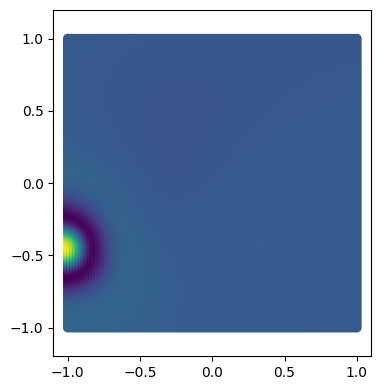

In [556]:
z2 = torch.normal(0, 1, size=(1, z_dim,))

x = torch.concat(
    (
        eval_s.unsqueeze(0).repeat(1, 1, 1),
        z2.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
    ),
    dim=-1
)

x = x.to(device)
r = model(x).squeeze(-1)

plt.figure(figsize=(4, 4))
plt.scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
plt.axis("equal") 
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


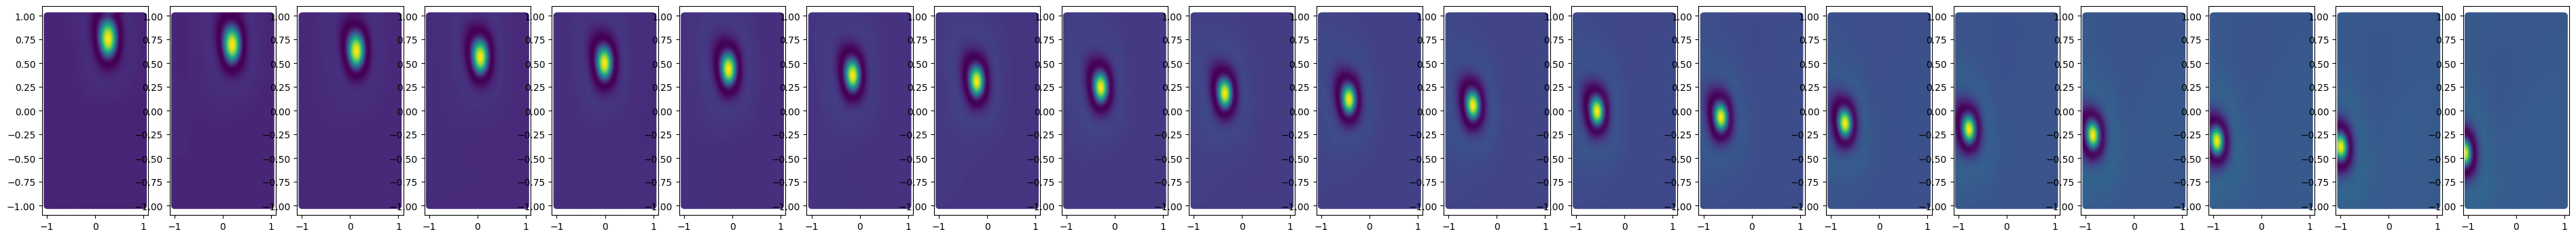

In [560]:
fig, axs = plt.subplots(1, 20, figsize=(4*12, 4))

for i, a in enumerate(tqdm(torch.linspace(0, 1, 20))):
    
    za = (1-a)*z1 + a*z2
    
    x = torch.concat(
        (
            eval_s.unsqueeze(0).repeat(1, 1, 1),
            za.unsqueeze(1).repeat(1, eval_s.shape[0], 1)
        ),
        dim=-1
    )

    x = x.to(device)
    r = model(x).squeeze(-1)

    axs[i].scatter(eval_s[:, 0], eval_s[:, 1], c=r.detach().cpu())
    # plt.show()
    

In [44]:
r.shape

torch.Size([10, 10000, 1])